In [373]:
import music21
import numpy as np
import matplotlib.pyplot as plt
from music21 import *
import re

class music_attributes:
    
    durations = []  #Each note durations
    notes = []
    offsets = []    #Each note start time
    endsets = []    #Each note end time
    single_notes = []   #only single note at all
    per_bar = []
    per_bar_only_notes =[]  #only single note at all
    per_note = []


def note_to_int(note): 

    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    if ('#-' in note):
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[3]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('#' in note): # not totally sure, source: http://www.pianofinders.com/educational/WhatToCallTheKeys1.htm
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('-' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    else:
        first_letter = note[0]
        base_val = note_base_name.index(first_letter)
        octave = note[1]
        value = base_val + 12*(int(octave)-(-1))
        
    return value


def check_float(duration): # this function fix the issue which comes from some note's duration. 
                           # For instance some note has duration like 14/3 or 7/3. 
    if ('/' in duration):
        numerator = float(duration.split('/')[0])
        denominator = float(duration.split('/')[1])
        duration = str(float(numerator/denominator))
    return duration

def midi_to_matrix(filename, length=250): # convert midi file to matrix for DL architecture.
    
    midi = music21.converter.parse(filename)
    notes_to_parse = None

    parts = music21.instrument.partitionByInstrument(midi)
    
    instrument_names = []
    
    try:
        for instrument in parts: # learn names of instruments
            name = (str(instrument).split(' ')[-1])[:-1]
            instrument_names.append(name)
    
    except TypeError:
        print ('Type is not iterable.')
        return None
    
    # just take piano part
    try:
        piano_index = instrument_names.index('Piano')
    except ValueError:
        print ('%s have not any Piano part' %(filename))
        return None
    
    notes_to_parse = parts.parts[piano_index].recurse()
    
    #duration_piano = float(check_float((str(notes_to_parse._getDuration()).split(' ')[-1])[:-1]))
    '''
    durations = []  #Each note durations
    notes = []
    offsets = []    #Each note start time
    '''
    
    for element in notes_to_parse:
        if isinstance(element, note.Note): # if it is single note
            music_attributes.notes.append(note_to_int(str(element.pitch)))
            duration = str(element.duration)[27:-1]
            music_attributes.durations.append(check_float(duration))
            music_attributes.offsets.append(element.offset)

        elif isinstance(element, chord.Chord): # if it is chord
            music_attributes.notes.append('.'.join(str(note_to_int(str(n)))
                                  for n in element.pitches))
            duration = str(element.duration)[27:-1]
            music_attributes.durations.append(check_float(duration))
            music_attributes.offsets.append(element.offset)
    
    
    
    for element in range(len(music_attributes.notes)):   #Per note's attributes
        note_attributes = []
        note_attributes.append(music_attributes.notes[element])
        note_attributes.append(music_attributes.durations[element])
        note_attributes.append(music_attributes.offsets[element])
        music_attributes.per_note.append(note_attributes)
        if isinstance(music_attributes.notes[element], str):    #Single notes
            music_attributes.single_notes.append(float(music_attributes.notes[element][-2:]))
        else:
            music_attributes.single_notes.append(music_attributes.notes[element])

    time_signature = (parts[meter.TimeSignature][0]).ratioString
    time_per_bar = (time_signature[0])    #Time signature's numerator     
    
    bar_attributes = []
    each_bar = float(time_per_bar)
    
    for element in music_attributes.per_note:    #Per bars attributes
        if element[2] < each_bar:
            bar_attributes.append(element)
        
            if element == music_attributes.per_note[-1]: 
                music_attributes.per_bar.append(bar_attributes)
                bar_attributes =[]
        else:
            music_attributes.per_bar.append(bar_attributes)
            bar_attributes = []
            bar_attributes.append(element)
            each_bar += float(time_per_bar)
    
    
    for element in music_attributes.per_bar:    #Per bars only note's attributes
        note_attributes = []
        for note_in_bar in element:
            if isinstance(note_in_bar[0], str):
                note_attributes.append(int(note_in_bar[0][-2:]))
            else:
                note_attributes.append(note_in_bar[0])
        music_attributes.per_bar_only_notes.append(note_attributes)
    
    for element in music_attributes.per_note:
        music_attributes.endsets.append(float(element[1]) + float(element[2]))
    

In [374]:
midi_path='./music_files/test/bloody.mid'
midi_to_matrix(midi_path, length=250)
#arr = np.array(music_attributes.per_bar,dtype=object)
#print((arr).shape)
(music_attributes.per_note)[:10],(music_attributes.endsets)[:10]

([[81, '0.25', 0.0],
  [45, '2.0', 0.0],
  [76, '0.25', 0.25],
  [88, '0.25', 0.5],
  [76, '0.25', 0.75],
  [86, '0.25', 1.0],
  [76, '0.25', 1.25],
  [84, '0.25', 1.5],
  [76, '0.25', 1.75],
  [83, '0.25', 2.0]],
 [0.25, 2.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25])

[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1]
 [0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

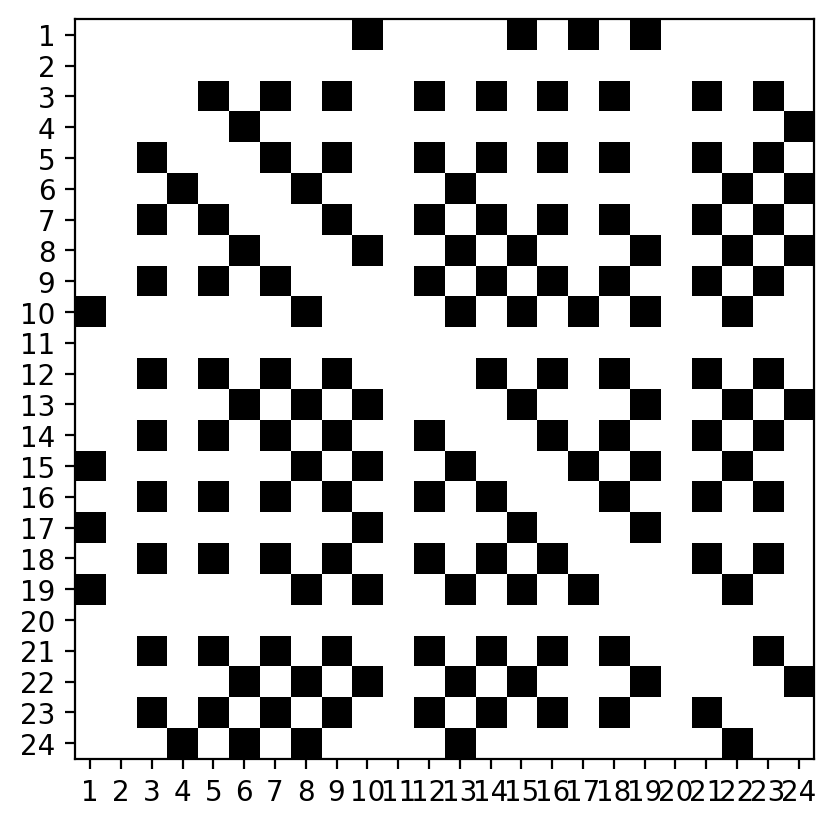

In [375]:
##Relationship of bars and melody

def visualize_adjacency_matrix(adjacency_matrix):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("binary")
    n = len(adjacency_matrix)
    
    im = ax.imshow(adjacency_matrix, cmap=cmap)
    
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(np.arange(1, n + 1))
    ax.set_yticklabels(np.arange(1, n + 1))
    '''
    for i in range(n):
        for j in range(n):
            value = adjacency_matrix[i][j]
            ax.text(j, i, value, ha="center", va="center", color="r")
    '''        
    plt.show()

class bars:     #Bar's relationship

    def calculate_pitch_intervals(notes):
        pitch_intervals = []
        for i in range(len(notes) - 1):
            current_note_pitch = notes[i]
            next_note_pitch = notes[i + 1]
            interval = next_note_pitch- current_note_pitch
            pitch_intervals.append(interval)
        return pitch_intervals

    def extract_melodic_features(notes):
        # 提取旋律特徵（例如，音高間隔）
        pitch_intervals = bars.calculate_pitch_intervals(notes)
        #print(pitch_intervals)
        # 根據需要添加其他特徵
        return pitch_intervals


    def find_repeated_relationships_between_bars(nested_notes):
        relationships = []

        for i in range(len(nested_notes) - 1):
            current_measure_features = bars.extract_melodic_features(nested_notes[i])
            for j in range((len(nested_notes) - 1), i, - 1):
                next_measure_features = bars.extract_melodic_features(nested_notes[j])
                if current_measure_features == next_measure_features:
                    relationships.append((i, j))
                #print(i,j)
        
        return relationships
    
    

    def create_adjacency_matrix(notes, status): #create_adjacency_matrix
        n = len(notes)
        adjacency_matrix = [[0 for _ in range(n)] for _ in range(n)]

        if status == 'rhythm':
            for i, j in bars.find_repeated_relationships_between_bars(notes):
                adjacency_matrix[i][j] = 1

        return adjacency_matrix

class melody:   #Melody's relationship

    def has_pitch_and_rhythm_relation(note1, note2):
        # requirement of each pitch or duration
        pitch_diff = abs(float(note1[0]) - float(note2[0]))
        duration_diff = abs(float(note1[1]) - float(note2[1]))
        #print(pitch_diff,note1,note2, duration_diff)
        # Ex:pitches difference with in 2 pitch,and both on the same duration 
        return pitch_diff <= 2.0 and duration_diff == 0.0

    def sametime_beat_in_note(per_bar_dur, per_bar_offset):
        pass

    def create_adjacency_matrix(notes, status): #create_adjacency_matrix
        n = len(notes)
        adjacency_matrix = [[0 for _ in range(n)] for _ in range(n)]

        if status == 'rhythm':
            for i in range(n):
                for j in range(n):
                    if i != j and melody.has_pitch_and_rhythm_relation(notes[i], notes[j]):
                        adjacency_matrix[i][j] = 1
        elif status == 'beat':
            pass

        return np.array(adjacency_matrix)

melody_ryhthm = melody.create_adjacency_matrix(music_attributes.per_note, 'rhythm')
adjacency_matrix = (melody_ryhthm)[0:24,:24] #Just take front of 24th bars to see

melody_pitches_to_beat = melody.create_adjacency_matrix(music_attributes.per_note, 'beat')


#bar_repeat = bars.create_adjacency_matrix(music_attributes.per_bar_only_notes, 'rhythm')
#bar_repeat = np.array(bar_repeat)


#print((bar_repeat).shape)
print(adjacency_matrix)
visualize_adjacency_matrix(adjacency_matrix)

In [376]:

#
'''
beat_grouped_notes = []
current_beat = music_attributes.offsets[0]
current_group = []
for note, beat in zip(music_attributes.notes, music_attributes.offsets):
    if beat != current_beat:
        beat_grouped_notes.append(current_group)
        current_group = []
        current_beat = beat
    current_group.append(note)
beat_grouped_notes.append(current_group)

num_notes = len(music_attributes.notes)
relation_matrix = np.zeros((num_notes, num_notes))
for group in beat_grouped_notes:
    num_group_notes = len(group)
    for i in range(num_group_notes):
        for j in range(num_group_notes):
            if i != j:
                note_i = music_attributes.notes.index(group[i])
                note_j = music_attributes.notes.index(group[j])
                relation_matrix[note_i, note_j] = 1
                relation_matrix[note_j, note_i] = 1



print((relation_matrix)[0:24,:24])
relation_matrix = relation_matrix[0:24,:24]
visualize_adjacency_matrix(relation_matrix)
'''



'\nbeat_grouped_notes = []\ncurrent_beat = music_attributes.offsets[0]\ncurrent_group = []\nfor note, beat in zip(music_attributes.notes, music_attributes.offsets):\n    if beat != current_beat:\n        beat_grouped_notes.append(current_group)\n        current_group = []\n        current_beat = beat\n    current_group.append(note)\nbeat_grouped_notes.append(current_group)\n\nnum_notes = len(music_attributes.notes)\nrelation_matrix = np.zeros((num_notes, num_notes))\nfor group in beat_grouped_notes:\n    num_group_notes = len(group)\n    for i in range(num_group_notes):\n        for j in range(num_group_notes):\n            if i != j:\n                note_i = music_attributes.notes.index(group[i])\n                note_j = music_attributes.notes.index(group[j])\n                relation_matrix[note_i, note_j] = 1\n                relation_matrix[note_j, note_i] = 1\n\n\n\nprint((relation_matrix)[0:24,:24])\nrelation_matrix = relation_matrix[0:24,:24]\nvisualize_adjacency_matrix(relati

In [377]:
# 取得所有音符的起始時間和結束時間
start_times = music_attributes.notes
end_times = music_attributes.endsets

# 取得所有音符所在節拍的時間
beat_times = music_attributes.durations

# 找出所有在同一節拍內的音符
beat_grouped_notes = []
current_beat = beat_times[0]
current_group = []
for note, start_time, end_time, beat in zip(music_attributes.per_note, start_times, end_times, beat_times):
    if beat != current_beat:
        beat_grouped_notes.append(current_group)
        current_group = []
        current_beat = beat
    # 如果音符的起始時間在上一個音符的持續時間內，將它加入到同一組中
    if len(current_group) != 0:
        if start_time < float(current_group[-1]) + float(current_group[-1]):
            current_group.append(note[0])
    else:
        current_group = [note[0]]
    #print(beat_grouped_notes,current_beat,current_group)
beat_grouped_notes.append(current_group)

# 創建音符對關係矩陣
num_notes = len(music_attributes.notes)
relation_matrix = np.zeros((num_notes, num_notes))

# 對每個在同一節拍內的音符，計算與其他音符的關係
for group in beat_grouped_notes:
    num_group_notes = len(group)
    for i in range(num_group_notes):
        for j in range(num_group_notes):
            if i != j:
                note_i = music_attributes.notes(group[i])
                note_j = music_attributes.notes(group[j])
                relation_matrix[note_i, note_j] = 1
                relation_matrix[note_j, note_i] = 1

# 打印關係矩陣
#print(relation_matrix)
print((relation_matrix)[:24,:24])
#visualize_adjacency_matrix((relation_matrix)[:24,:24])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/zed/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_785543/3453117438.py", line 19, in <module>
    if start_time < float(current_group[-1]) + float(current_group[-1]):
TypeError: '<' not supported between instances of 'str' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/zed/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/zed/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/zed/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  Fi

In [378]:

import numpy as np

def get_notes_in_beat(file_path):
    midi = converter.parse(file_path)
    beats = []
    
    for part in midi.parts:
        for measure in part.getElementsByClass(stream.Measure):
            beat_notes = []
            for item in measure.notesAndRests:
                if item.isNote:
                    beat_notes.append(item.pitch.midi)
            beats.append(beat_notes)
    
    return beats

def build_adjacency_matrix(beats):
    adjacency_matrices = []
    
    for beat in beats:
        n = len(beat)
        adjacency_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i + 1, n):
                if beat[i] != beat[j]:
                    adjacency_matrix[i, j] = 1
                    adjacency_matrix[j, i] = 1
                    
        adjacency_matrices.append(adjacency_matrix)
    
    return adjacency_matrices

midi_file = "./music_files/test/bloody.mid"

beats = get_notes_in_beat(midi_file)
adjacency_matrices = build_adjacency_matrix(beats)

for idx, beat_matrix in enumerate(adjacency_matrices):
    print(f"Bar {idx + 1} adjaceny martrices：")
    print(beat_matrix)
    print("\n")

#print(adjacency_matrices)

Bar 1 adjaceny martrices：
[[0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


Bar 2 adjaceny martrices：
[[0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


Bar 3 adjaceny martrices：
[[0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


Bar 4 adjaceny martrices：
[[0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


Bar 5 adjaceny martr